In [1]:
!pip install ipyleaflet
!pip install pystac
!pip install pystac-client
!pip install odc-stac
!pip install planetary-computer
!pip install rich
!pip install catboost
!pip install shap

  Using cached python_dotenv-1.0.0-py3-none-any.whl (19 kB)
  Using cached catboost-1.1.1-cp310-none-manylinux1_x86_64.whl (76.6 MB)
  Using cached plotly-5.14.1-py2.py3-none-any.whl (15.3 MB)
  Using cached shap-0.41.0-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (572 kB)
  Using cached slicer-0.0.7-py3-none-any.whl (14 kB)


In [2]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import statsmodels.api as sm
from scipy.stats import skew, norm, probplot
from sklearn import tree

# Feature Engineering
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor, cv, Pool
import shap

from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.pipeline import Pipeline
# Planetary Computer Tools
import pystac
import pystac_client
import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
import planetary_computer as pc

# Please pass your API key here
pc.settings.set_subscription_key('f9fde6370efa456d8774c701a260c224')

# Others
import requests
import rich.table
from itertools import cycle
from tqdm import tqdm
tqdm.pandas()
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

In [3]:
crop_yield_data = pd.read_csv("Crop_Yield_Data_challenge_2.csv")
crop_yield_data.head()

,District,Latitude,Longitude,"Season(SA = Summer Autumn, WS = Winter Spring)","Rice Crop Intensity(D=Double, T=Triple)",Date of Harvest,Field size (ha),Rice Yield (kg/ha)
0,Chau_Phu,10.510542,105.248554,SA,T,15-07-2022,3.40,5500
1,Chau_Phu,10.509150,105.265098,SA,T,15-07-2022,2.43,6000
2,Chau_Phu,10.467721,105.192464,SA,D,15-07-2022,1.95,6400
3,Chau_Phu,10.494453,105.241281,SA,T,15-07-2022,4.30,6000
4,Chau_Phu,10.535058,105.252744,SA,D,14-07-2022,3.30,6400


In [4]:
def get_sentinel_data(longitude, latitude, season,assests,box_size_deg):
    
    '''
    Returns a list of VV,VH, VV/VH values for a given latitude and longitude over a given time period (based on the season)
    Attributes:
    longitude - Longitude
    latitude - Latitude
    season - The season for which band values need to be extracted.
    assets - A list of bands to be extracted
    
    '''
    vh_list = []
    vv_list= []
    vv_by_vh_list = []
    rvi_list = []
    
    
    bands_of_interest = assests
    if season == 'SA':
        time_slice = "2022-05-01/2022-08-31"
    if season == 'WS':
        time_slice = "2022-01-01/2022-04-30"
        
    
    bbox_of_interest = ((float(longitude)-box_size_deg/2), (float(latitude)-box_size_deg/2), (float(longitude)+box_size_deg/2), (float(latitude)+box_size_deg/2))
    time_of_interest = time_slice
    
    catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    search = catalog.search(collections=["sentinel-1-rtc"], bbox=bbox_of_interest, datetime=time_of_interest)
    items = list(search.get_all_items())
    item = items[0]
    items.reverse()
    
    data = stac_load([items[1]],bands=bands_of_interest, patch_url=pc.sign, bbox=bbox_of_interest).isel(time=0)

    for item in items:
        data = stac_load([item],bands=["vv", "vh"], patch_url=pc.sign, bbox=bbox_of_interest, crs="EPSG:4326", resolution=10 / 111320.0)
        if(data['vh'].values[0][0][0]!=-32768.0 and data['vv'].values[0][0][0]!=-32768.0):
            data = data.where(~data.isnull(), 0)
            vh = data["vh"].astype("float64")
            vv = data["vv"].astype("float64")
            vv_list.append(np.median(vv))
            vh_list.append(np.median(vh))
            vv_by_vh_list.append(np.median(vv)/np.median(vh))
            rvi_list.append(((1 - np.median(vv) / (np.median(vv) + np.median(vh))) ** 0.5) * 4 * (np.median(vh) / (np.median(vv) + np.median(vh))))
            
            
    return vv_list, vh_list, vv_by_vh_list, rvi_list

In [9]:
## Get Sentinel-1-RTC Data
assests = ['vh','vv']
# set box_degree_size
box_size_degree = 0.0004
train_band_values=crop_yield_data.progress_apply(lambda x: get_sentinel_data(x['Longitude'], x['Latitude'],x['Season(SA = Summer Autumn, WS = Winter Spring)'],assests,box_size_degree), axis=1)
vv = [x[0] for x in train_band_values]
vh = [x[1] for x in train_band_values]
vv_by_vh= [x[2] for x in train_band_values]
rvi = [x[3] for x in train_band_values]



In [ ]:
vv_vh_rvi_data = pd.DataFrame(list(zip(vv,vh,vv_by_vh,rvi)),columns = ["vv_list","vh_list","vv_by_vh_list","rvi_list"])

In [ ]:
def ordinal_distribution(data, dx=3, dy=1, taux=1, tauy=1, return_missing=False, tie_precision=None):
    '''
    Returns
    -------
     : tuple
       Tuple containing two arrays, one with the ordinal patterns occurring in data 
       and another with their corresponding probabilities.
       
    Attributes
    ---------
    data : array 
           Array object in the format :math:`[x_{1}, x_{2}, x_{3}, \\ldots ,x_{n}]`
           or  :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]`.
    dx : int
         Embedding dimension (horizontal axis) (default: 3).
    dy : int
         Embedding dimension (vertical axis); it must be 1 for time series 
         (default: 1).
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    tauy : int
           Embedding delay (vertical axis) (default: 1).
    return_missing: boolean
                    If `True`, it returns ordinal patterns not appearing in the 
                    symbolic sequence obtained from **data** are shown. If `False`,
                    these missing patterns (permutations) are omitted 
                    (default: `False`).
    tie_precision : int
                    If not `None`, **data** is rounded with `tie_precision`
                    number of decimals (default: `None`).
   
    '''
    def setdiff(a, b):
        '''
        Returns
        -------
        : array
            An array containing the elements in `a` that are not contained in `b`.
            
        Parameters
        ----------    
        a : tuples, lists or arrays
            Array in the format :math:`[[x_{21}, x_{22}, x_{23}, \\ldots, x_{2m}], 
            \\ldots, [x_{n1}, x_{n2}, x_{n3}, ..., x_{nm}]]`.
        b : tuples, lists or arrays
            Array in the format :math:`[[x_{21}, x_{22}, x_{23}, \\ldots, x_{2m}], 
            \\ldots, [x_{n1}, x_{n2}, x_{n3}, ..., x_{nm}]]`.
        '''

        a = np.asarray(a).astype('int64')
        b = np.asarray(b).astype('int64')

        _, ncols = a.shape

        dtype={'names':['f{}'.format(i) for i in range(ncols)],
            'formats':ncols * [a.dtype]}

        C = np.setdiff1d(a.view(dtype), b.view(dtype))
        C = C.view(a.dtype).reshape(-1, ncols)

        return(C)

    try:
        ny, nx = np.shape(data)
        data   = np.array(data)
    except:
        nx     = np.shape(data)[0]
        ny     = 1
        data   = np.array([data])

    if tie_precision is not None:
        data = np.round(data, tie_precision)

    partitions = np.concatenate(
        [
            [np.concatenate(data[j:j+dy*tauy:tauy,i:i+dx*taux:taux]) for i in range(nx-(dx-1)*taux)] 
            for j in range(ny-(dy-1)*tauy)
        ]
    )

    symbols = np.apply_along_axis(np.argsort, 1, partitions)
    symbols, symbols_count = np.unique(symbols, return_counts=True, axis=0)

    probabilities = symbols_count/len(partitions)

    if return_missing==False:
        return symbols, probabilities
    
    else:
        all_symbols   = list(map(list,list(itertools.permutations(np.arange(dx*dy)))))
        miss_symbols  = setdiff(all_symbols, symbols)
        symbols       = np.concatenate((symbols, miss_symbols))
        probabilities = np.concatenate((probabilities, np.zeros(miss_symbols.__len__())))
        
        return symbols, probabilities

In [ ]:
def permutation_entropy(data, dx=3, dy=1, taux=1, tauy=1, base=2, normalized=True, probs=False, tie_precision=None):
    '''
    Returns Permutation Entropy
    Attributes:
    data : array
           Array object in the format :math:`[x_{1}, x_{2}, x_{3}, \\ldots ,x_{n}]`
           or  :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]`
           or an ordinal probability distribution (such as the ones returned by :func:`ordpy.ordinal_distribution`).
    dx :   int
           Embedding dimension (horizontal axis) (default: 3).
    dy :   int
           Embedding dimension (vertical axis); it must be 1 for time series (default: 1).
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    tauy : int
           Embedding delay (vertical axis) (default: 1).
    base : str, int
           Logarithm base in Shannon's entropy. Either 'e' or 2 (default: 2).
    normalized: boolean
                If `True`, permutation entropy is normalized by its maximum value 
                (default: `True`). If `False`, it is not.
    probs : boolean
            If `True`, assumes **data** is an ordinal probability distribution. If 
            `False`, **data** is expected to be a one- or two-dimensional 
            array (default: `False`). 
    tie_precision : int
                    If not `None`, **data** is rounded with `tie_precision`
                    number of decimals (default: `None`).
    '''
    if not probs:
        _, probabilities = ordinal_distribution(data, dx, dy, taux, tauy, return_missing=False, tie_precision=tie_precision)
    else:
        probabilities = np.asarray(data)
        probabilities = probabilities[probabilities>0]

    if normalized==True and base in [2, '2']:        
        smax = np.log2(float(np.math.factorial(dx*dy)))
        s    = -np.sum(probabilities*np.log2(probabilities))
        return s/smax
         
    elif normalized==True and base=='e':        
        smax = np.log(float(np.math.factorial(dx*dy)))
        s    = -np.sum(probabilities*np.log(probabilities))
        return s/smax
    
    elif normalized==False and base in [2, '2']:
        return -np.sum(probabilities*np.log2(probabilities))
    else:
        return -np.sum(probabilities*np.log(probabilities))

In [ ]:
def generate_stastical_features(dataframe):
    '''
    Returns a  list of statistical features such as min,max,range,mean,auto-correlation,permutation entropy for each of the features
    Attributes:
    dataframe - DataFrame consisting of VV,VH and VV/VH for a time period
    '''
    features_list = []
    for index, row in dataframe.iterrows():
        min_vv = min(row[0])
        max_vv = max(row[0])
        range_vv = max_vv - min_vv
        mean_vv = np.mean(row[0])
        correlation_vv = sm.tsa.acf(row[0])[1]   
        permutation_entropy_vv = permutation_entropy(row[0], dx=6,base=2, normalized=True)
       
    
        min_vh = min(row[1])
        max_vh = max(row[1])
        range_vh = max_vh - min_vh
        mean_vh = np.mean(row[1])
        correlation_vh = sm.tsa.acf(row[1])[1]
        permutation_entropy_vh = permutation_entropy(row[1], dx=6, base=2, normalized=True)
        
        
        min_vv_by_vh = min(row[2])
        max_vv_by_vh = max(row[2])
        range_vv_by_vh = max_vv_by_vh - min_vv_by_vh
        mean_vv_by_vh = np.mean(row[2])
        correlation_vv_by_vh = sm.tsa.acf(row[2])[1]
        permutation_entropy_vv_by_vh = permutation_entropy(row[2], dx=6, base=2, normalized=True)
        
        min_rvi = min(row[3])
        max_rvi = max(row[3])
        range_rvi = max_rvi - min_rvi
        mean_rvi = np.mean(row[3])
        correlation_rvi = sm.tsa.acf(row[3])[1]
        permutation_entropy_rvi = permutation_entropy(row[3], dx=6, base=2, normalized=True)
        
    
        features_list.append([min_vv, max_vv, range_vv, mean_vv, correlation_vv, permutation_entropy_vv,
                             min_vh, max_vh, range_vh, mean_vh, correlation_vh, permutation_entropy_vh,
                             min_vv_by_vh, max_vv_by_vh, range_vv_by_vh,  mean_vv_by_vh, correlation_vv_by_vh, permutation_entropy_vv_by_vh,
                             min_rvi, max_rvi, range_rvi, mean_rvi, correlation_rvi, permutation_entropy_rvi])
    return features_list

In [ ]:
# Generating Statistical Features for VV,VH and VV/VH and creating a dataframe
features = generate_stastical_features(vv_vh_rvi_data)
features_sentinel1_data = pd.DataFrame(features ,columns =
                                       ['min_vv', 'max_vv', 'range_vv','mean_vv', 'correlation_vv', 'permutation_entropy_vv',
                                        'min_vh', 'max_vh', 'range_vh','mean_vh', 'correlation_vh', 'permutation_entropy_vh',
                                        'min_vv_by_vh', 'max_vv_by_vh', 'range_vv_by_vh', 'mean_vv_by_vh', 'correlation_vv_by_vh', 'permutation_entropy_vv_by_vh',
                                        'min_rvi', 'max_rvi', 'range_rvi', 'mean_rvi',  'correlation_rvi', 'permutation_entropy_rvi'] )

In [ ]:
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined 
    dataset2 - Dataset 2 to be combined
    '''
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [ ]:
crop_data = combine_two_datasets(features_sentinel1_data,crop_yield_data[['Rice Yield (kg/ha)', 'District']])
crop_data.head(3)

### DATA CLEANING

In [13]:
#Checking null values
crop_data.isna().sum()

min_vv                          0
max_vv                          0
range_vv                        0
mean_vv                         0
correlation_vv                  0
permutation_entropy_vv          0
min_vh                          0
max_vh                          0
range_vh                        0
mean_vh                         0
correlation_vh                  0
permutation_entropy_vh          0
min_vv_by_vh                    0
max_vv_by_vh                    0
range_vv_by_vh                  0
mean_vv_by_vh                   0
correlation_vv_by_vh            0
permutation_entropy_vv_by_vh    0
min_rvi                         0
max_rvi                         0
range_rvi                       0
mean_rvi                        0
correlation_rvi                 0
permutation_entropy_rvi         0
Rice Yield (kg/ha)              0
District                        0
dtype: int64

In [14]:
#checking for duplicates
crop_data[crop_data.duplicated()]

,min_vv,max_vv,range_vv,mean_vv,correlation_vv,permutation_entropy_vv,min_vh,max_vh,range_vh,mean_vh,...,correlation_vv_by_vh,permutation_entropy_vv_by_vh,min_rvi,max_rvi,range_rvi,mean_rvi,correlation_rvi,permutation_entropy_rvi,Rice Yield (kg/ha),District


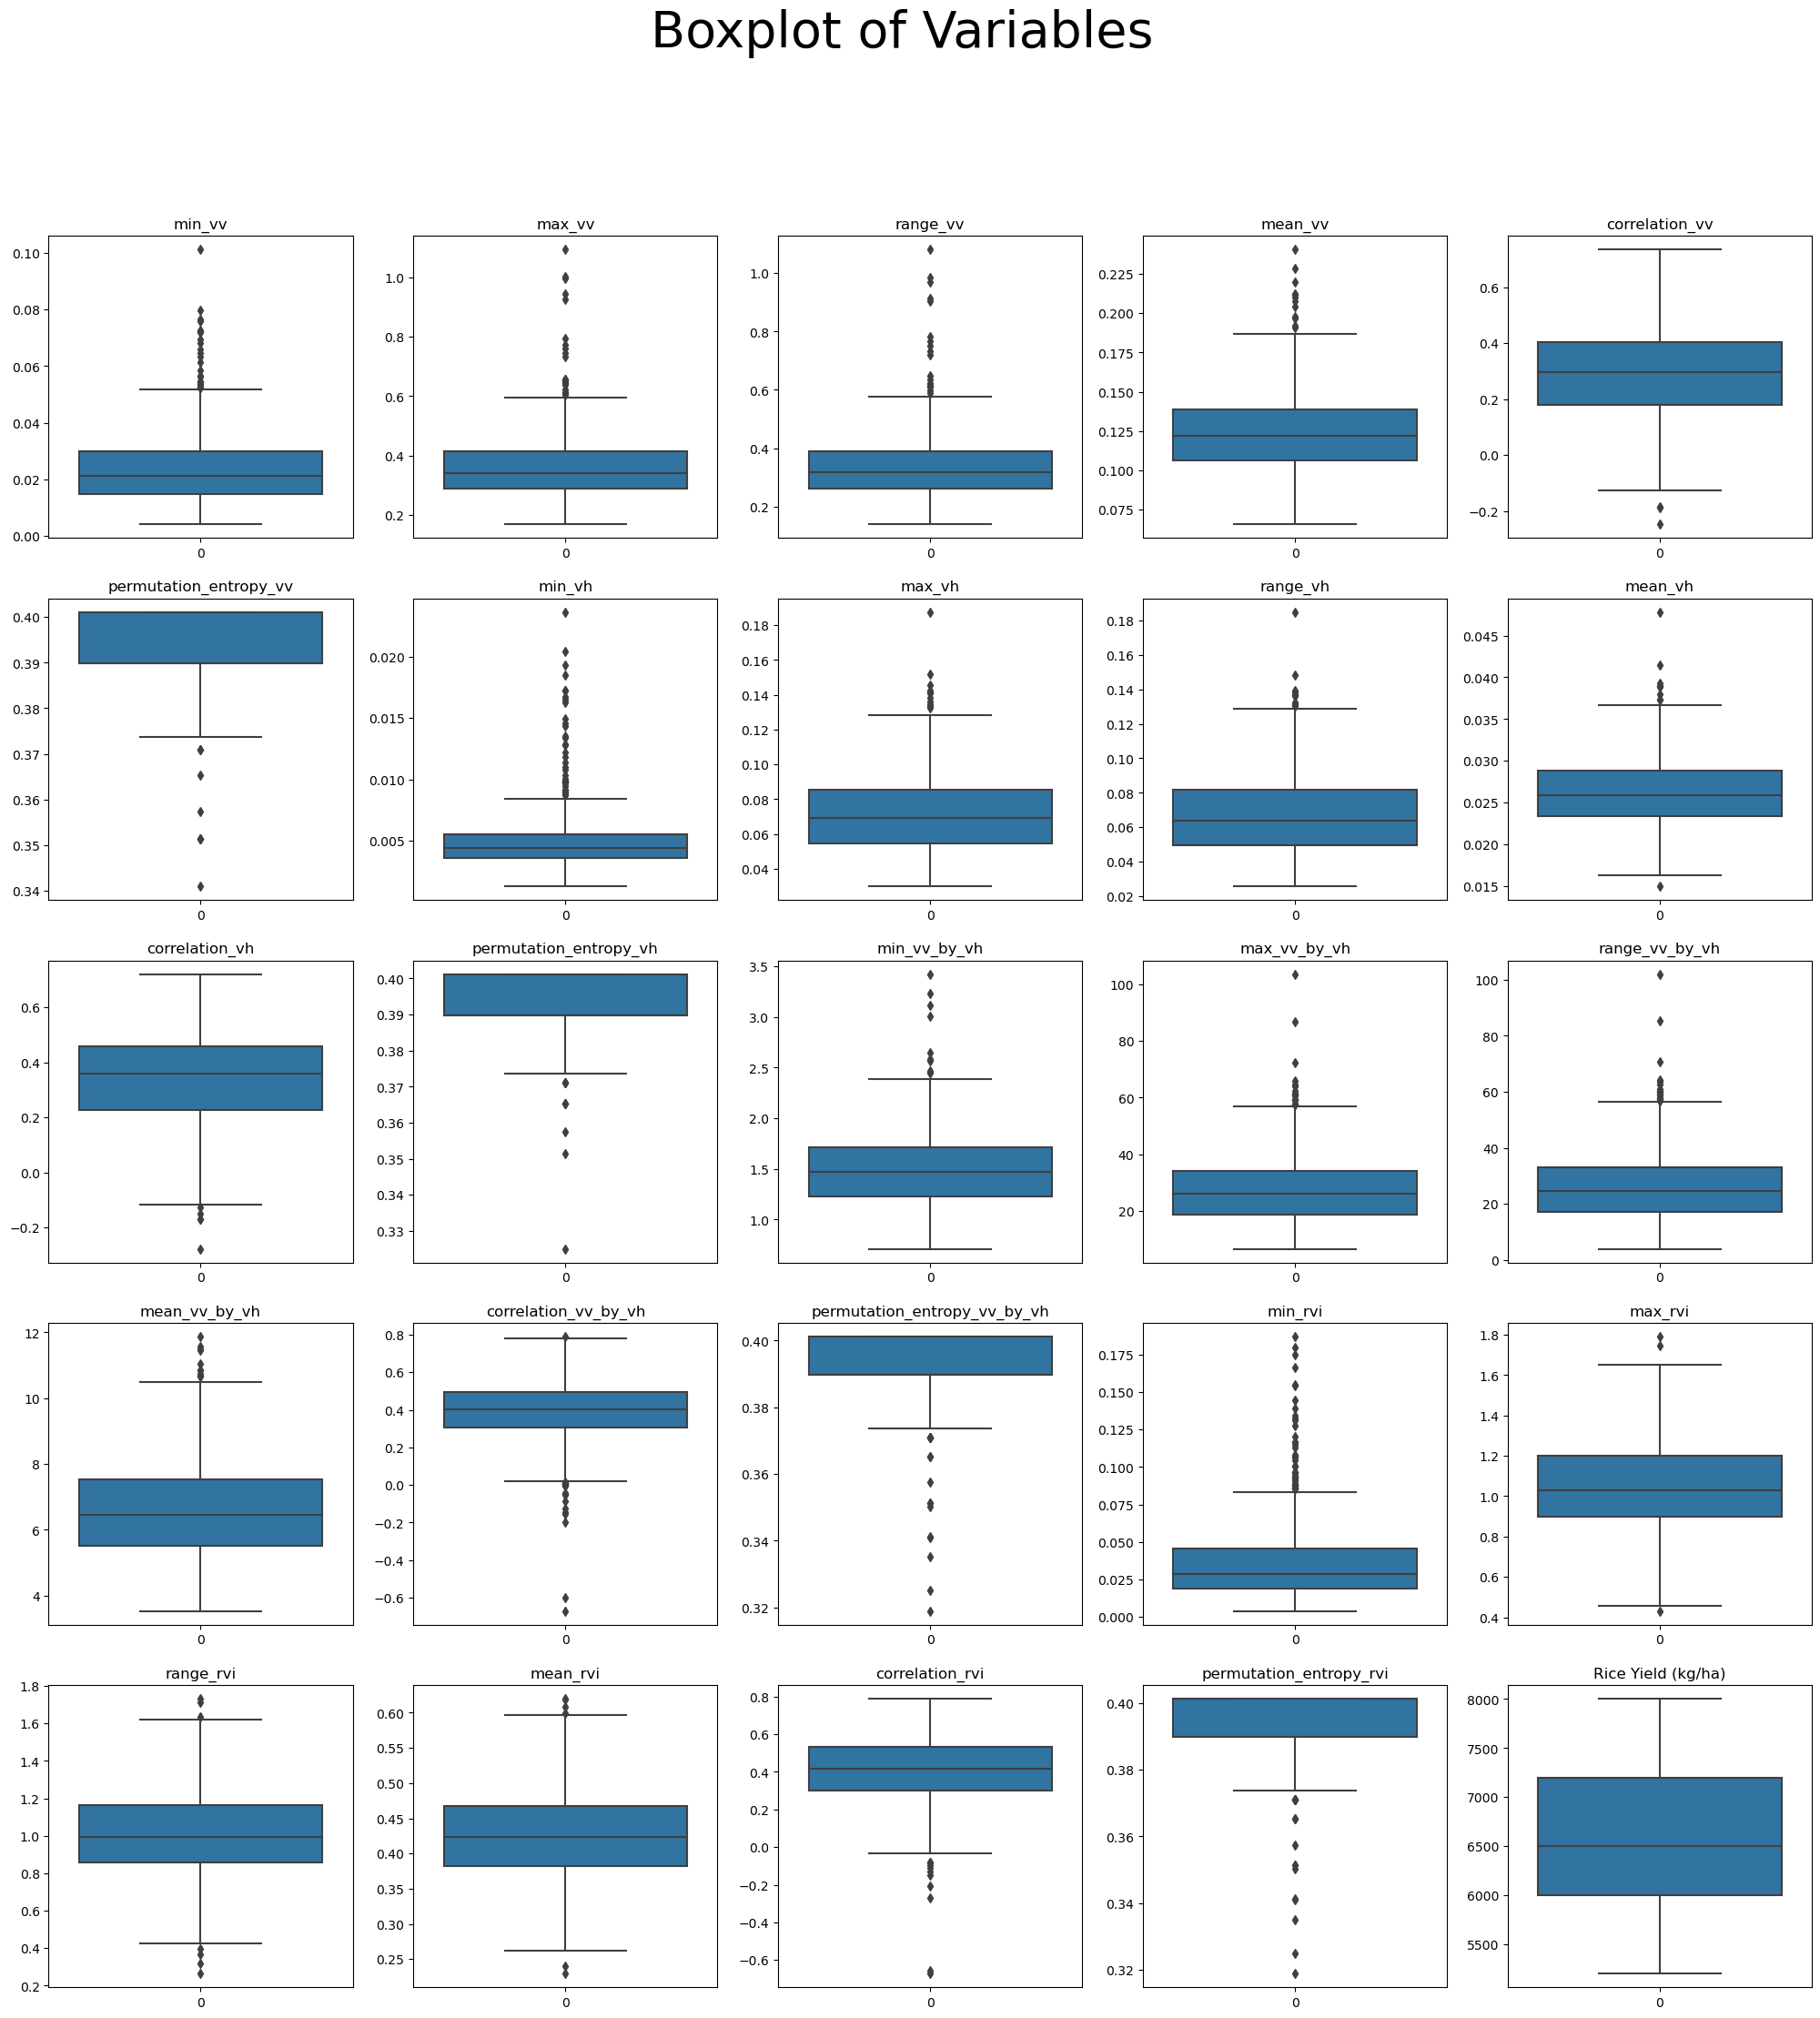

In [15]:
#Checking for outliers
variables = list(crop_data.columns)
nrow = 5
ncol = 5
fig, ax = plt.subplots(nrow, ncol, figsize=(25, 25))

for i in range(len(crop_data.columns) -1 ):
    ax[i//ncol, i%ncol].set_title(variables[i])
    sns.boxplot(crop_data.iloc[: , i], ax=ax[i//ncol, i%ncol])
    
fig.suptitle("Boxplot of Variables", fontsize=40);

In [18]:
#dropping all min, max and range columns
crop_data = crop_data[['mean_vv', 'correlation_vv', 'permutation_entropy_vv',
                        'mean_vh', 'correlation_vh', 'permutation_entropy_vh',
                        'mean_vv_by_vh', 'correlation_vv_by_vh', 'permutation_entropy_vv_by_vh',
                        'mean_rvi',  'correlation_rvi', 'permutation_entropy_rvi','Rice Yield (kg/ha)', 'District']]

### Feature engineering


 mu = 6631.31 and sigma = 794.82



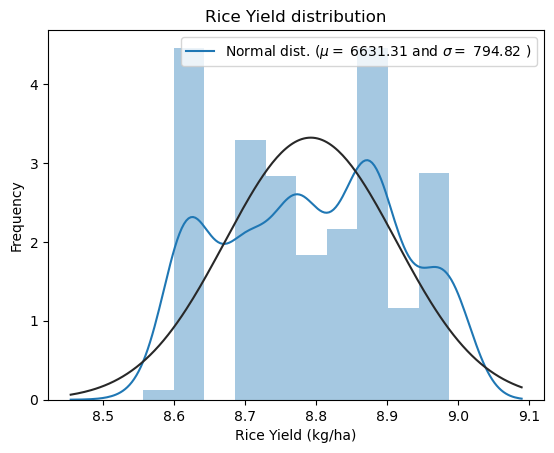

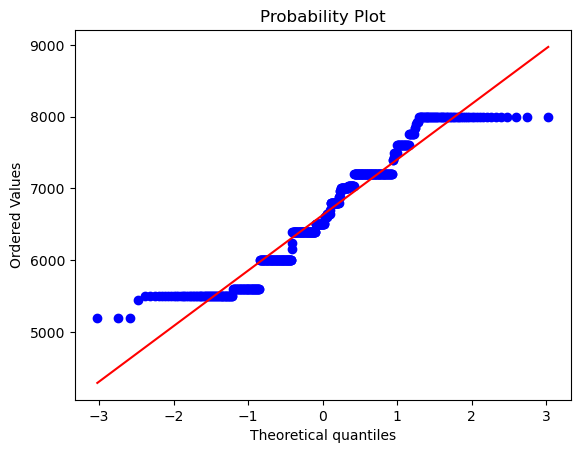

In [21]:
# Distribution plot of target varible
sns.distplot(np.log(crop_data['Rice Yield (kg/ha)']) , fit=norm);

(mu, sigma) = norm.fit(crop_data['Rice Yield (kg/ha)'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Rice Yield distribution')

# QQ-plot
fig = plt.figure()
res = probplot(crop_data['Rice Yield (kg/ha)'] , plot=plt)
plt.show()


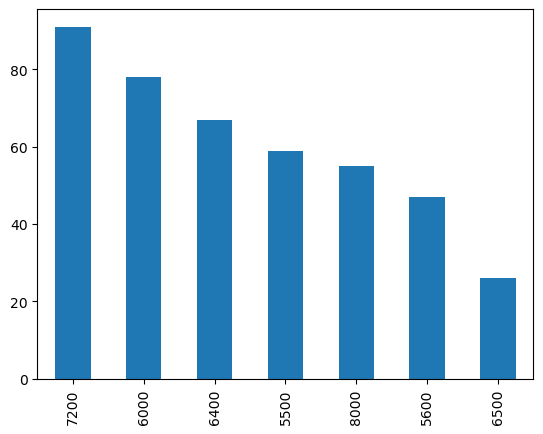

In [22]:
#getting top 6 yields
top_7 = (crop_data['Rice Yield (kg/ha)'].value_counts())[:7]


#plotting top 6 yields
top_7.plot(kind='bar');

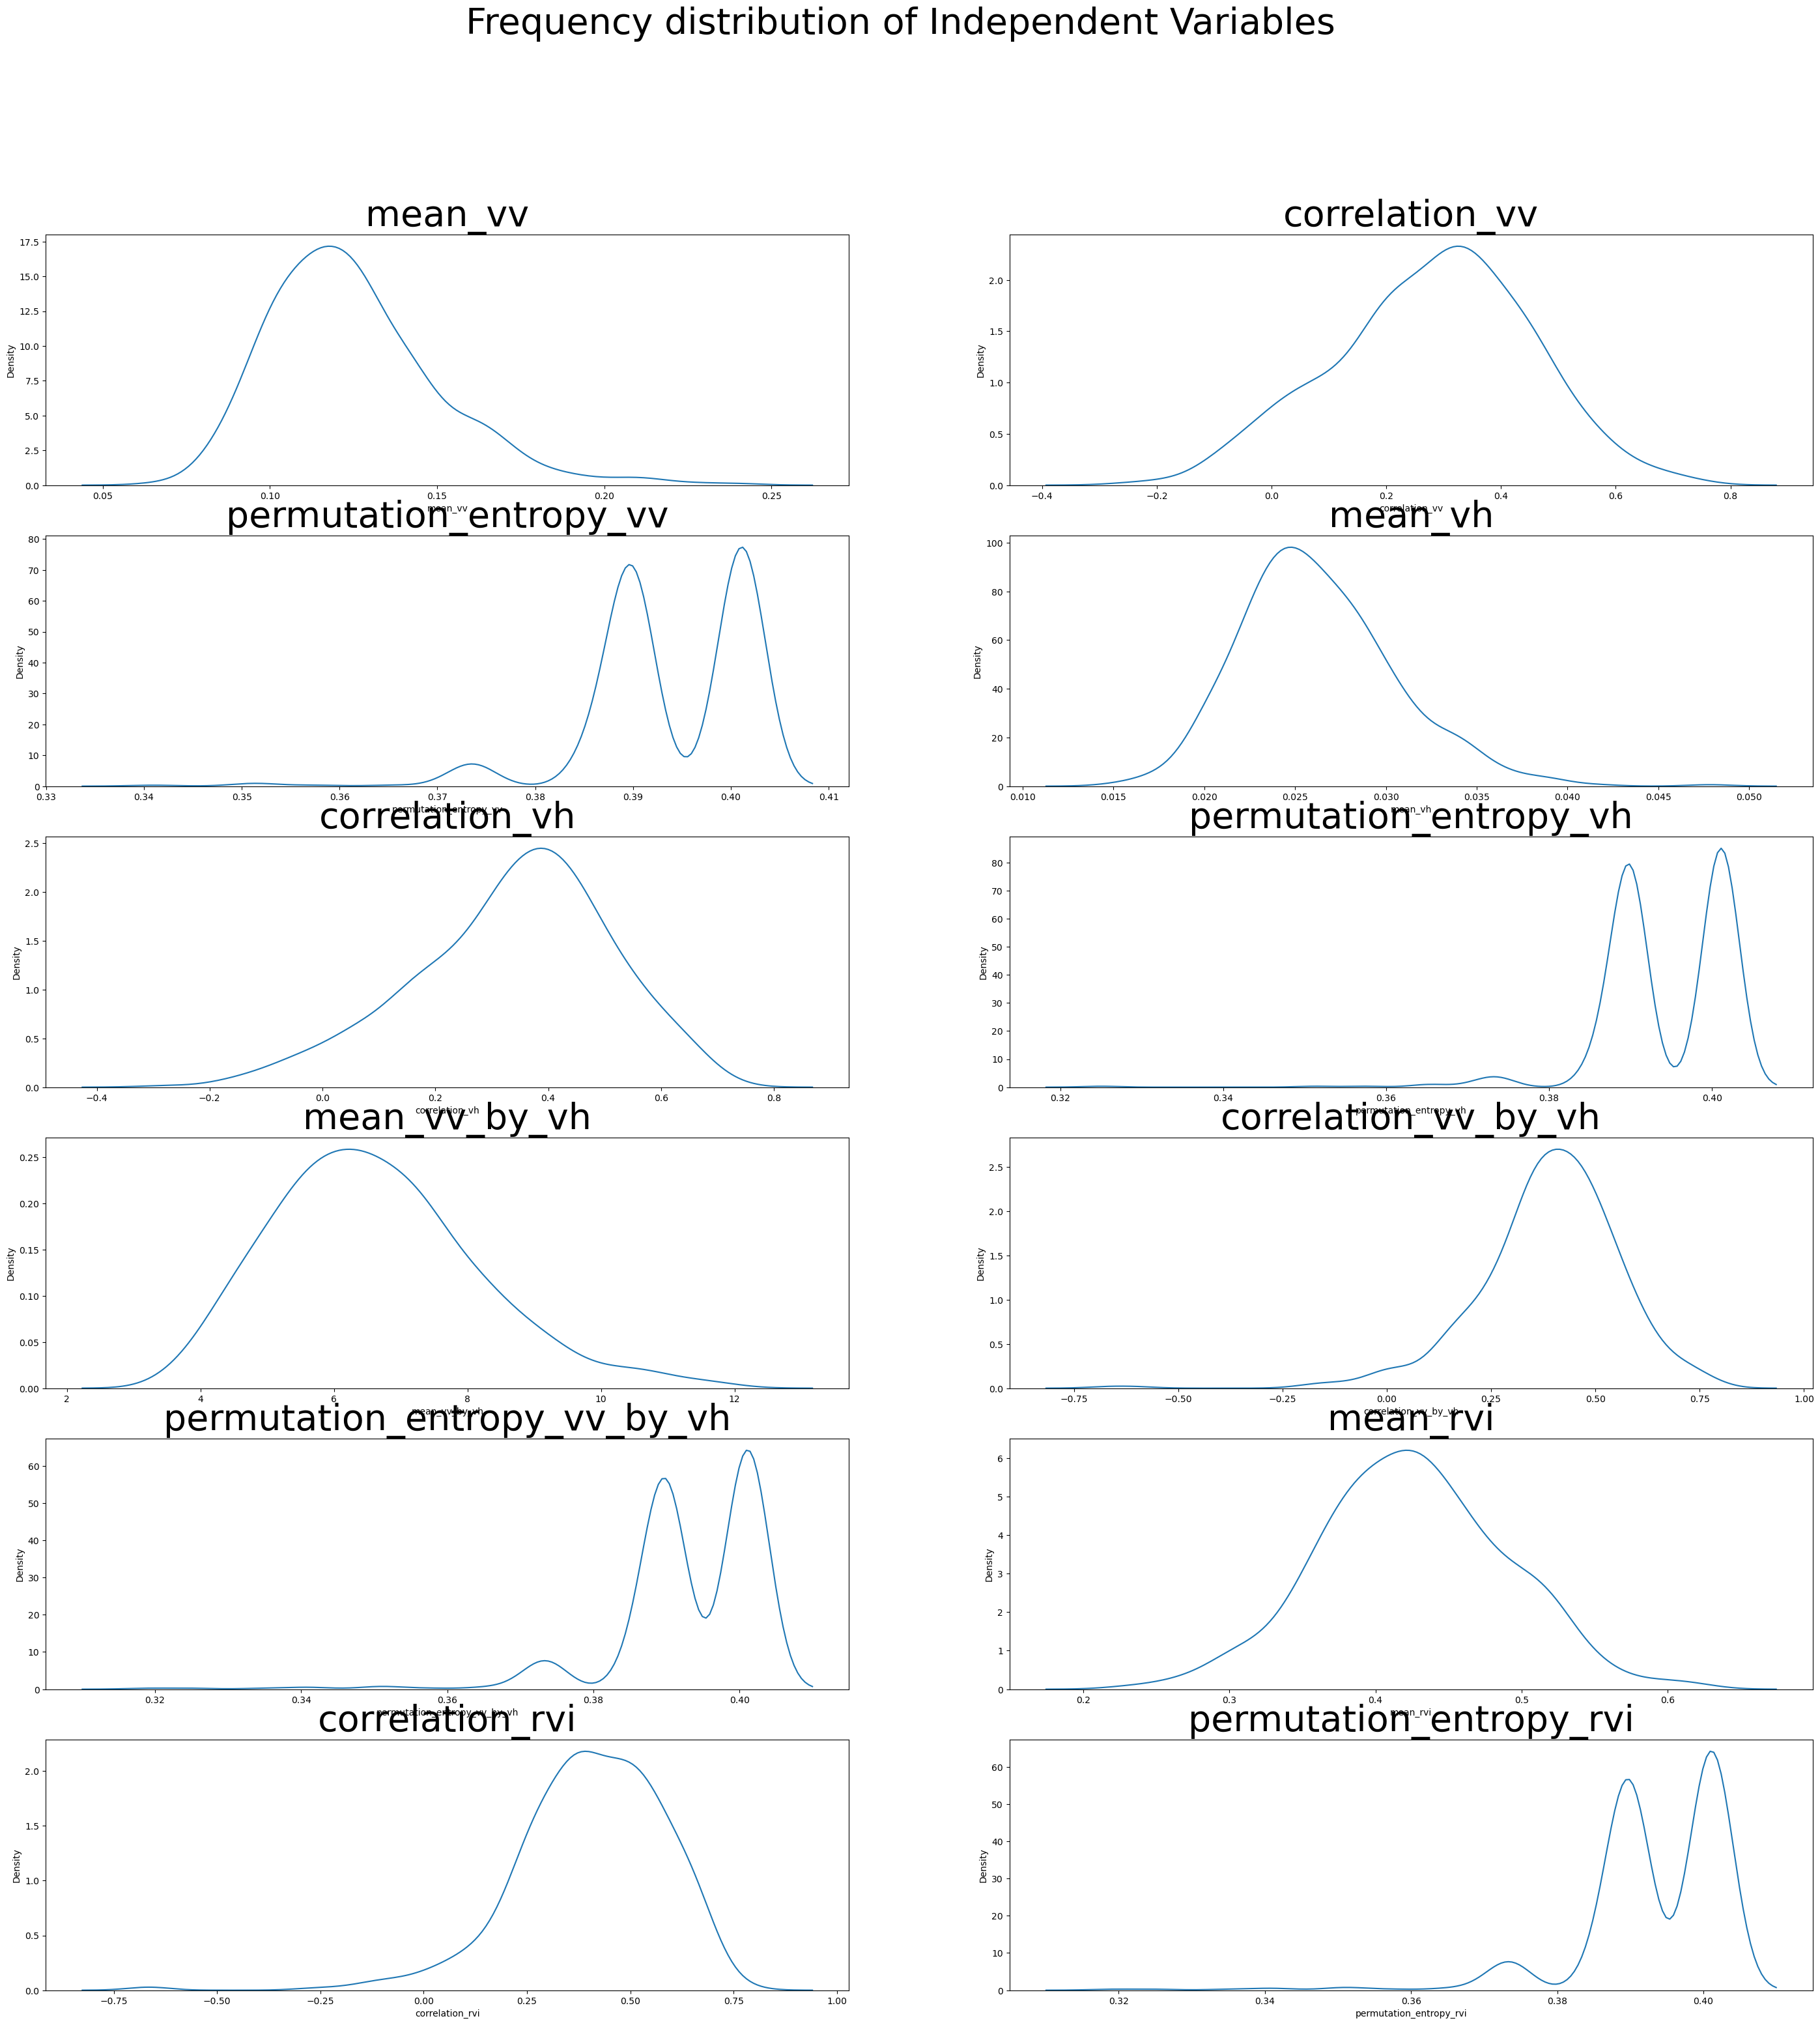

In [23]:
#Frequency distribution of Independent Variables
variables = list(crop_data.columns)
nrow = 6
ncol = 2
fig, ax = plt.subplots(nrow, ncol, figsize=(35, 35))

for i in range(len(crop_data.columns) -2 ):
   ax[i//ncol, i%ncol].set_title(variables[i], fontsize = 40)
   sns.kdeplot(crop_data.iloc[: , i], ax=ax[i//ncol, i%ncol])
   
    
fig.suptitle("Frequency distribution of Independent Variables", fontsize=40);

In [24]:
#Loading Artificial Data
sample = pd.read_csv("SampledData.csv")

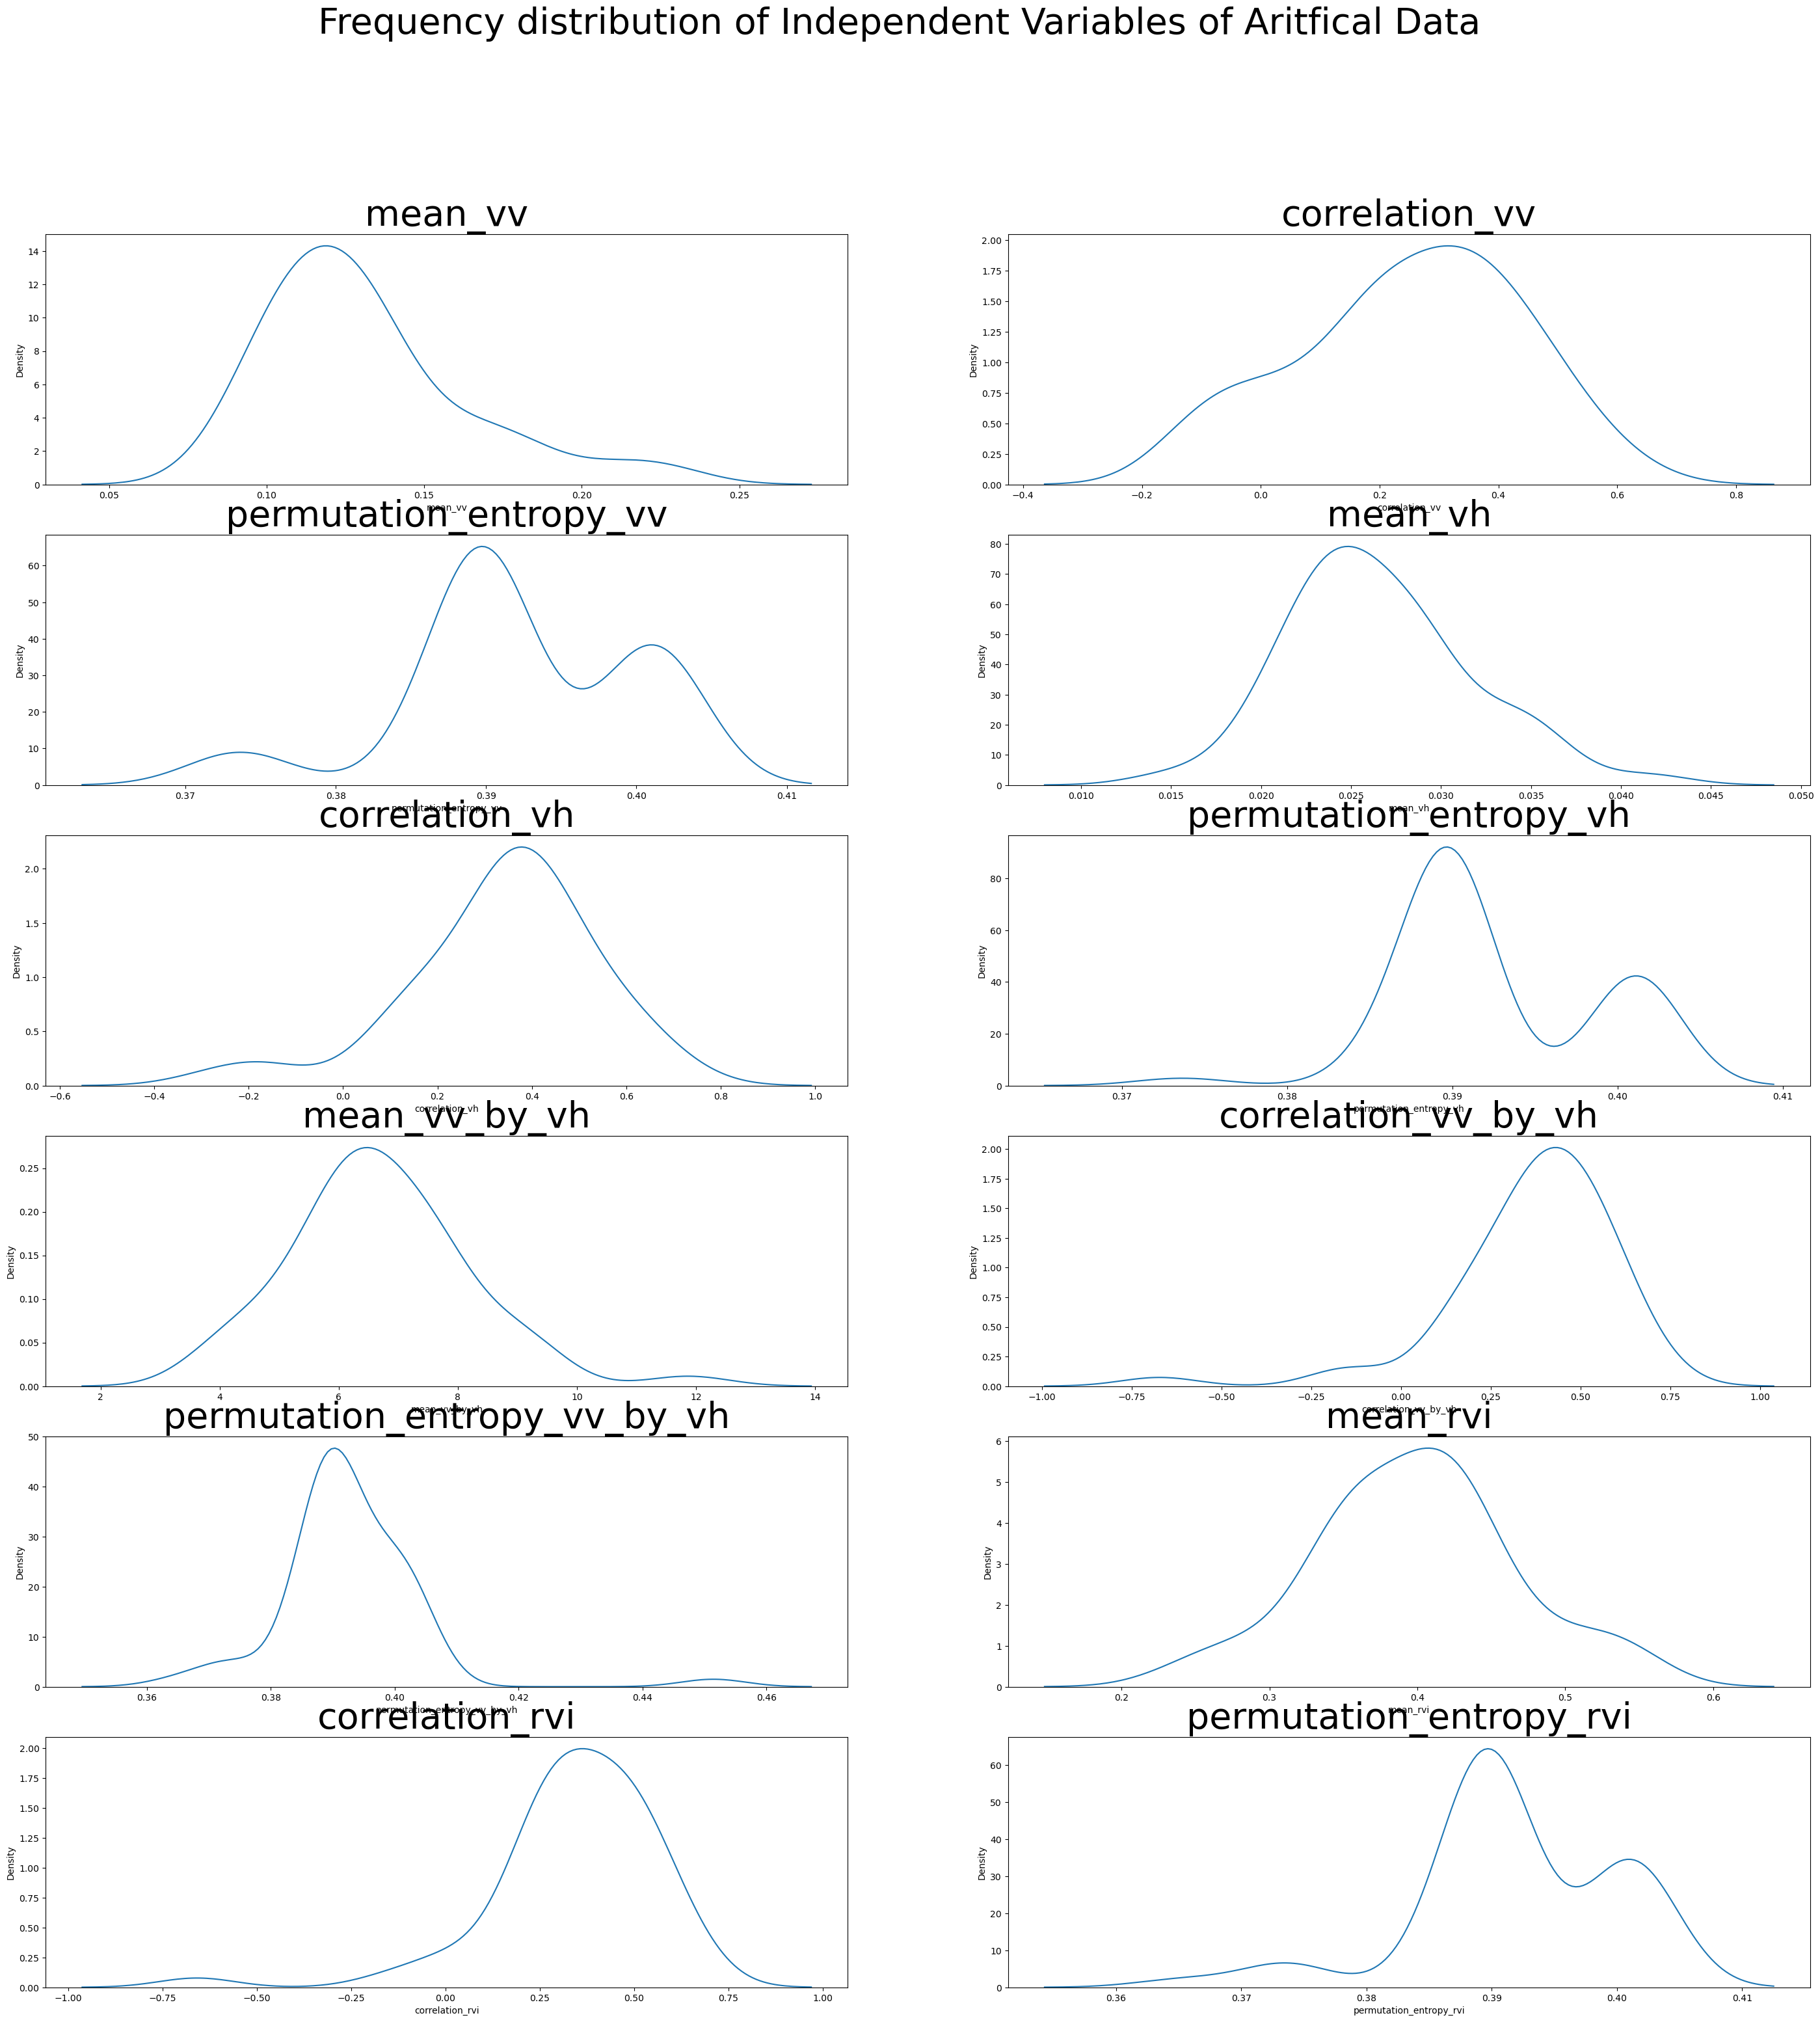

In [25]:
#Frequency distribution of Independent Variables
variables = list(sample.columns)
nrow = 6
ncol = 2
fig, ax = plt.subplots(nrow, ncol, figsize=(35, 35))

for i in range(len(sample.columns) -1 ):
   ax[i//ncol, i%ncol].set_title(variables[i], fontsize = 40)
   sns.kdeplot(sample.iloc[: , i], ax=ax[i//ncol, i%ncol])
   
    
fig.suptitle("Frequency distribution of Independent Variables of Aritfical Data", fontsize=40);

In [26]:
#Splitting data into training and evaluation set
crop_data = shuffle(crop_data, random_state = 27)
evaluation_set = crop_data.iloc[0:110,:]
training_set = crop_data.iloc[111:, :]

In [27]:
#Concatinating training set with aritificial data
training_set = training_set.drop('District', axis = 1)
training_set = pd.concat([training_set,sample], axis = 0)

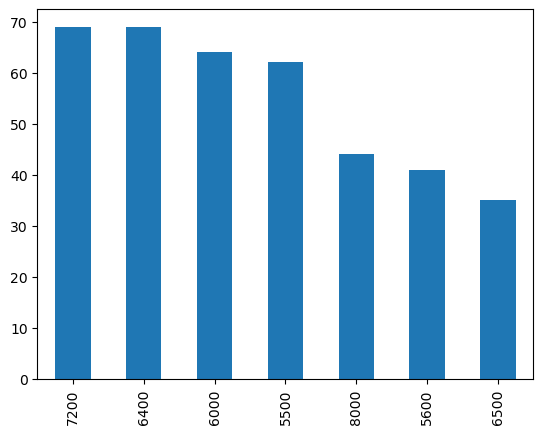

In [28]:
#getting top 7 yields after adding artificial data
top_7 = (training_set['Rice Yield (kg/ha)'].value_counts())[:7]


#plotting top 7 yields
top_7.plot(kind='bar');

### MODEL BUILDING

In [80]:
#spliting data for training
X_train = training_set.drop(columns=['Rice Yield (kg/ha)'])
y_train = training_set['Rice Yield (kg/ha)']


X_test = evaluation_set.drop(columns=['Rice Yield (kg/ha)', 'District'])
y_test = evaluation_set['Rice Yield (kg/ha)']


In [81]:
def model_selection(models,model_names, X_train, y_train):
    '''
    Returns a dataframe of various models and its r2 score
    ''' 
    
    scores = [] 
    for model in models:
        model.fit(X_train, y_train)
        model_predictions = model.predict(X_train)
        score = r2_score(model_predictions,  y_train)
        scores.append(score)
    df = pd.DataFrame({
    'Model' : model_names,
    'R2_Score' : scores
    })
    
    return df

In [82]:
models= [RandomForestRegressor(), CatBoostRegressor(), GradientBoostingRegressor(), 
         AdaBoostRegressor() , ExtraTreesRegressor(), DecisionTreeRegressor(), HistGradientBoostingRegressor()]

model_names = ["RandomForestRegressor", "CatBoostRegressor", "GradientBoostingRegressor", 
         "AdaBoostRegressor", "ExtraTreesRegressor", "DecisionTreeRegressor", "HistGradientBoostingRegressor"]

In [83]:
model_selection(models, model_names,  X_train, y_train)

Learning rate set to 0.036661
0:	learn: 777.3842796	total: 3.51ms	remaining: 3.5s
1:	learn: 761.9848726	total: 5.03ms	remaining: 2.51s
2:	learn: 746.8005720	total: 6.5ms	remaining: 2.16s
3:	learn: 732.9587041	total: 7.91ms	remaining: 1.97s
4:	learn: 720.2267431	total: 9.89ms	remaining: 1.97s
5:	learn: 706.9067082	total: 11.6ms	remaining: 1.92s
6:	learn: 694.1013591	total: 13ms	remaining: 1.84s
7:	learn: 682.6629052	total: 14.5ms	remaining: 1.79s
8:	learn: 671.4713324	total: 15.8ms	remaining: 1.74s
9:	learn: 661.0363089	total: 17.4ms	remaining: 1.72s
10:	learn: 650.1355230	total: 18.8ms	remaining: 1.69s
11:	learn: 640.2545411	total: 20.4ms	remaining: 1.68s
12:	learn: 629.9377758	total: 22ms	remaining: 1.67s
13:	learn: 621.1817236	total: 23.7ms	remaining: 1.67s
14:	learn: 612.0742606	total: 25.2ms	remaining: 1.65s
15:	learn: 602.6258413	total: 26.4ms	remaining: 1.62s
16:	learn: 594.6686030	total: 27.7ms	remaining: 1.6s
17:	learn: 586.8040296	total: 29.1ms	remaining: 1.59s
18:	learn: 579.

,Model,R2_Score
0,RandomForestRegressor,0.944592
1,CatBoostRegressor,0.980845
2,GradientBoostingRegressor,0.791138
3,AdaBoostRegressor,0.548723
4,ExtraTreesRegressor,1.000000
5,DecisionTreeRegressor,1.000000
6,HistGradientBoostingRegressor,0.961263


In [84]:
#TOP 3 MODELS
Catboost = CatBoostRegressor()
ExtraTrees = ExtraTreesRegressor()
DecisionTree = DecisionTreeRegressor()

In [112]:
#FITTING TOP 3 MODELS
Catboost.fit(X_train,y_train)
ExtraTrees.fit(X_train, y_train)
DecisionTree.fit(X_train, y_train)

0:	learn: 787.8581430	total: 1.3ms	remaining: 1.3s
1:	learn: 782.6557571	total: 2.48ms	remaining: 1.24s
2:	learn: 776.6861233	total: 3.55ms	remaining: 1.18s
3:	learn: 771.3124976	total: 4.68ms	remaining: 1.17s
4:	learn: 766.2145040	total: 5.65ms	remaining: 1.12s
5:	learn: 760.3735364	total: 7.43ms	remaining: 1.23s
6:	learn: 754.7817158	total: 8.39ms	remaining: 1.19s
7:	learn: 750.4012584	total: 9.41ms	remaining: 1.17s
8:	learn: 745.7352082	total: 10.3ms	remaining: 1.14s
9:	learn: 740.3075859	total: 11.2ms	remaining: 1.11s
10:	learn: 735.3197707	total: 12.5ms	remaining: 1.12s
11:	learn: 730.3454201	total: 13.4ms	remaining: 1.1s
12:	learn: 725.3099317	total: 14.4ms	remaining: 1.09s
13:	learn: 720.3348500	total: 15.6ms	remaining: 1.1s
14:	learn: 715.7799319	total: 16.8ms	remaining: 1.1s
15:	learn: 710.5846817	total: 17.6ms	remaining: 1.08s
16:	learn: 706.2430175	total: 20ms	remaining: 1.15s
17:	learn: 701.5749347	total: 20.8ms	remaining: 1.14s
18:	learn: 697.0595322	total: 21.6ms	remainin

DecisionTreeRegressor()

In [113]:
#prediction using top  3 models

Catboost_predictions = Catboost.predict(X_test)
Decisiontree_predictions = DecisionTree.predict(X_test)
Extratrees_predictions = ExtraTrees.predict(X_test)



print("Catboost Outsample R2 Score: {0:.2f}".format(r2_score(y_test,Catboost_predictions)))
print("Catboost Outsample R2 Score: {0:.2f}".format(r2_score(y_test,Decisiontree_predictions)))
print("Catboost Outsample R2 Score: {0:.2f}".format(r2_score(y_test,Extratrees_predictions)))

Catboost Outsample R2 Score: 0.67
Catboost Outsample R2 Score: 0.34
Catboost Outsample R2 Score: 0.66


In [87]:
#Reducing overfitting for catboost
train_pool = Pool(X_train, y_train)
eval_pool = Pool(X_test, y_test)

CatBoost = CatBoostRegressor(iterations=1000, learning_rate=0.015, l2_leaf_reg = 9,depth = 3)


CatBoost = CatBoost.fit(X_train, y_train, eval_set=eval_pool, early_stopping_rounds=10,  plot = True)



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 787.2687528	test: 776.6322797	best: 776.6322797 (0)	total: 687us	remaining: 687ms
1:	learn: 781.1212474	test: 770.6076291	best: 770.6076291 (1)	total: 1.74ms	remaining: 867ms
2:	learn: 775.0430494	test: 764.2002672	best: 764.2002672 (2)	total: 2.25ms	remaining: 748ms
3:	learn: 768.9922457	test: 757.7614118	best: 757.7614118 (3)	total: 2.67ms	remaining: 666ms
4:	learn: 763.3428265	test: 752.1645669	best: 752.1645669 (4)	total: 3.18ms	remaining: 633ms
5:	learn: 757.3562497	test: 746.0950608	best: 746.0950608 (5)	total: 3.58ms	remaining: 593ms
6:	learn: 751.4664319	test: 740.0742541	best: 740.0742541 (6)	total: 3.9ms	remaining: 553ms
7:	learn: 745.5172281	test: 733.7767531	best: 733.7767531 (7)	total: 4.32ms	remaining: 535ms
8:	learn: 740.1080947	test: 728.2635371	best: 728.2635371 (8)	total: 4.83ms	remaining: 531ms
9:	learn: 734.7202352	test: 722.5897627	best: 722.5897627 (9)	total: 5.38ms	remaining: 532ms
10:	learn: 729.6772177	test: 717.0416905	best: 717.0416905 (10)	total: 5

In [114]:
insample_predictions = CatBoost.predict(X_train)
print("CatBoost Insample R2 Score: {0:.2f}".format(r2_score(y_train,insample_predictions)))

outsample_predictions = CatBoost.predict(X_test)
print("CatBoost Outsample R2 Score: {0:.2f}".format(r2_score(y_test,outsample_predictions)))

CatBoost Insample R2 Score: 0.68
CatBoost Outsample R2 Score: 0.66


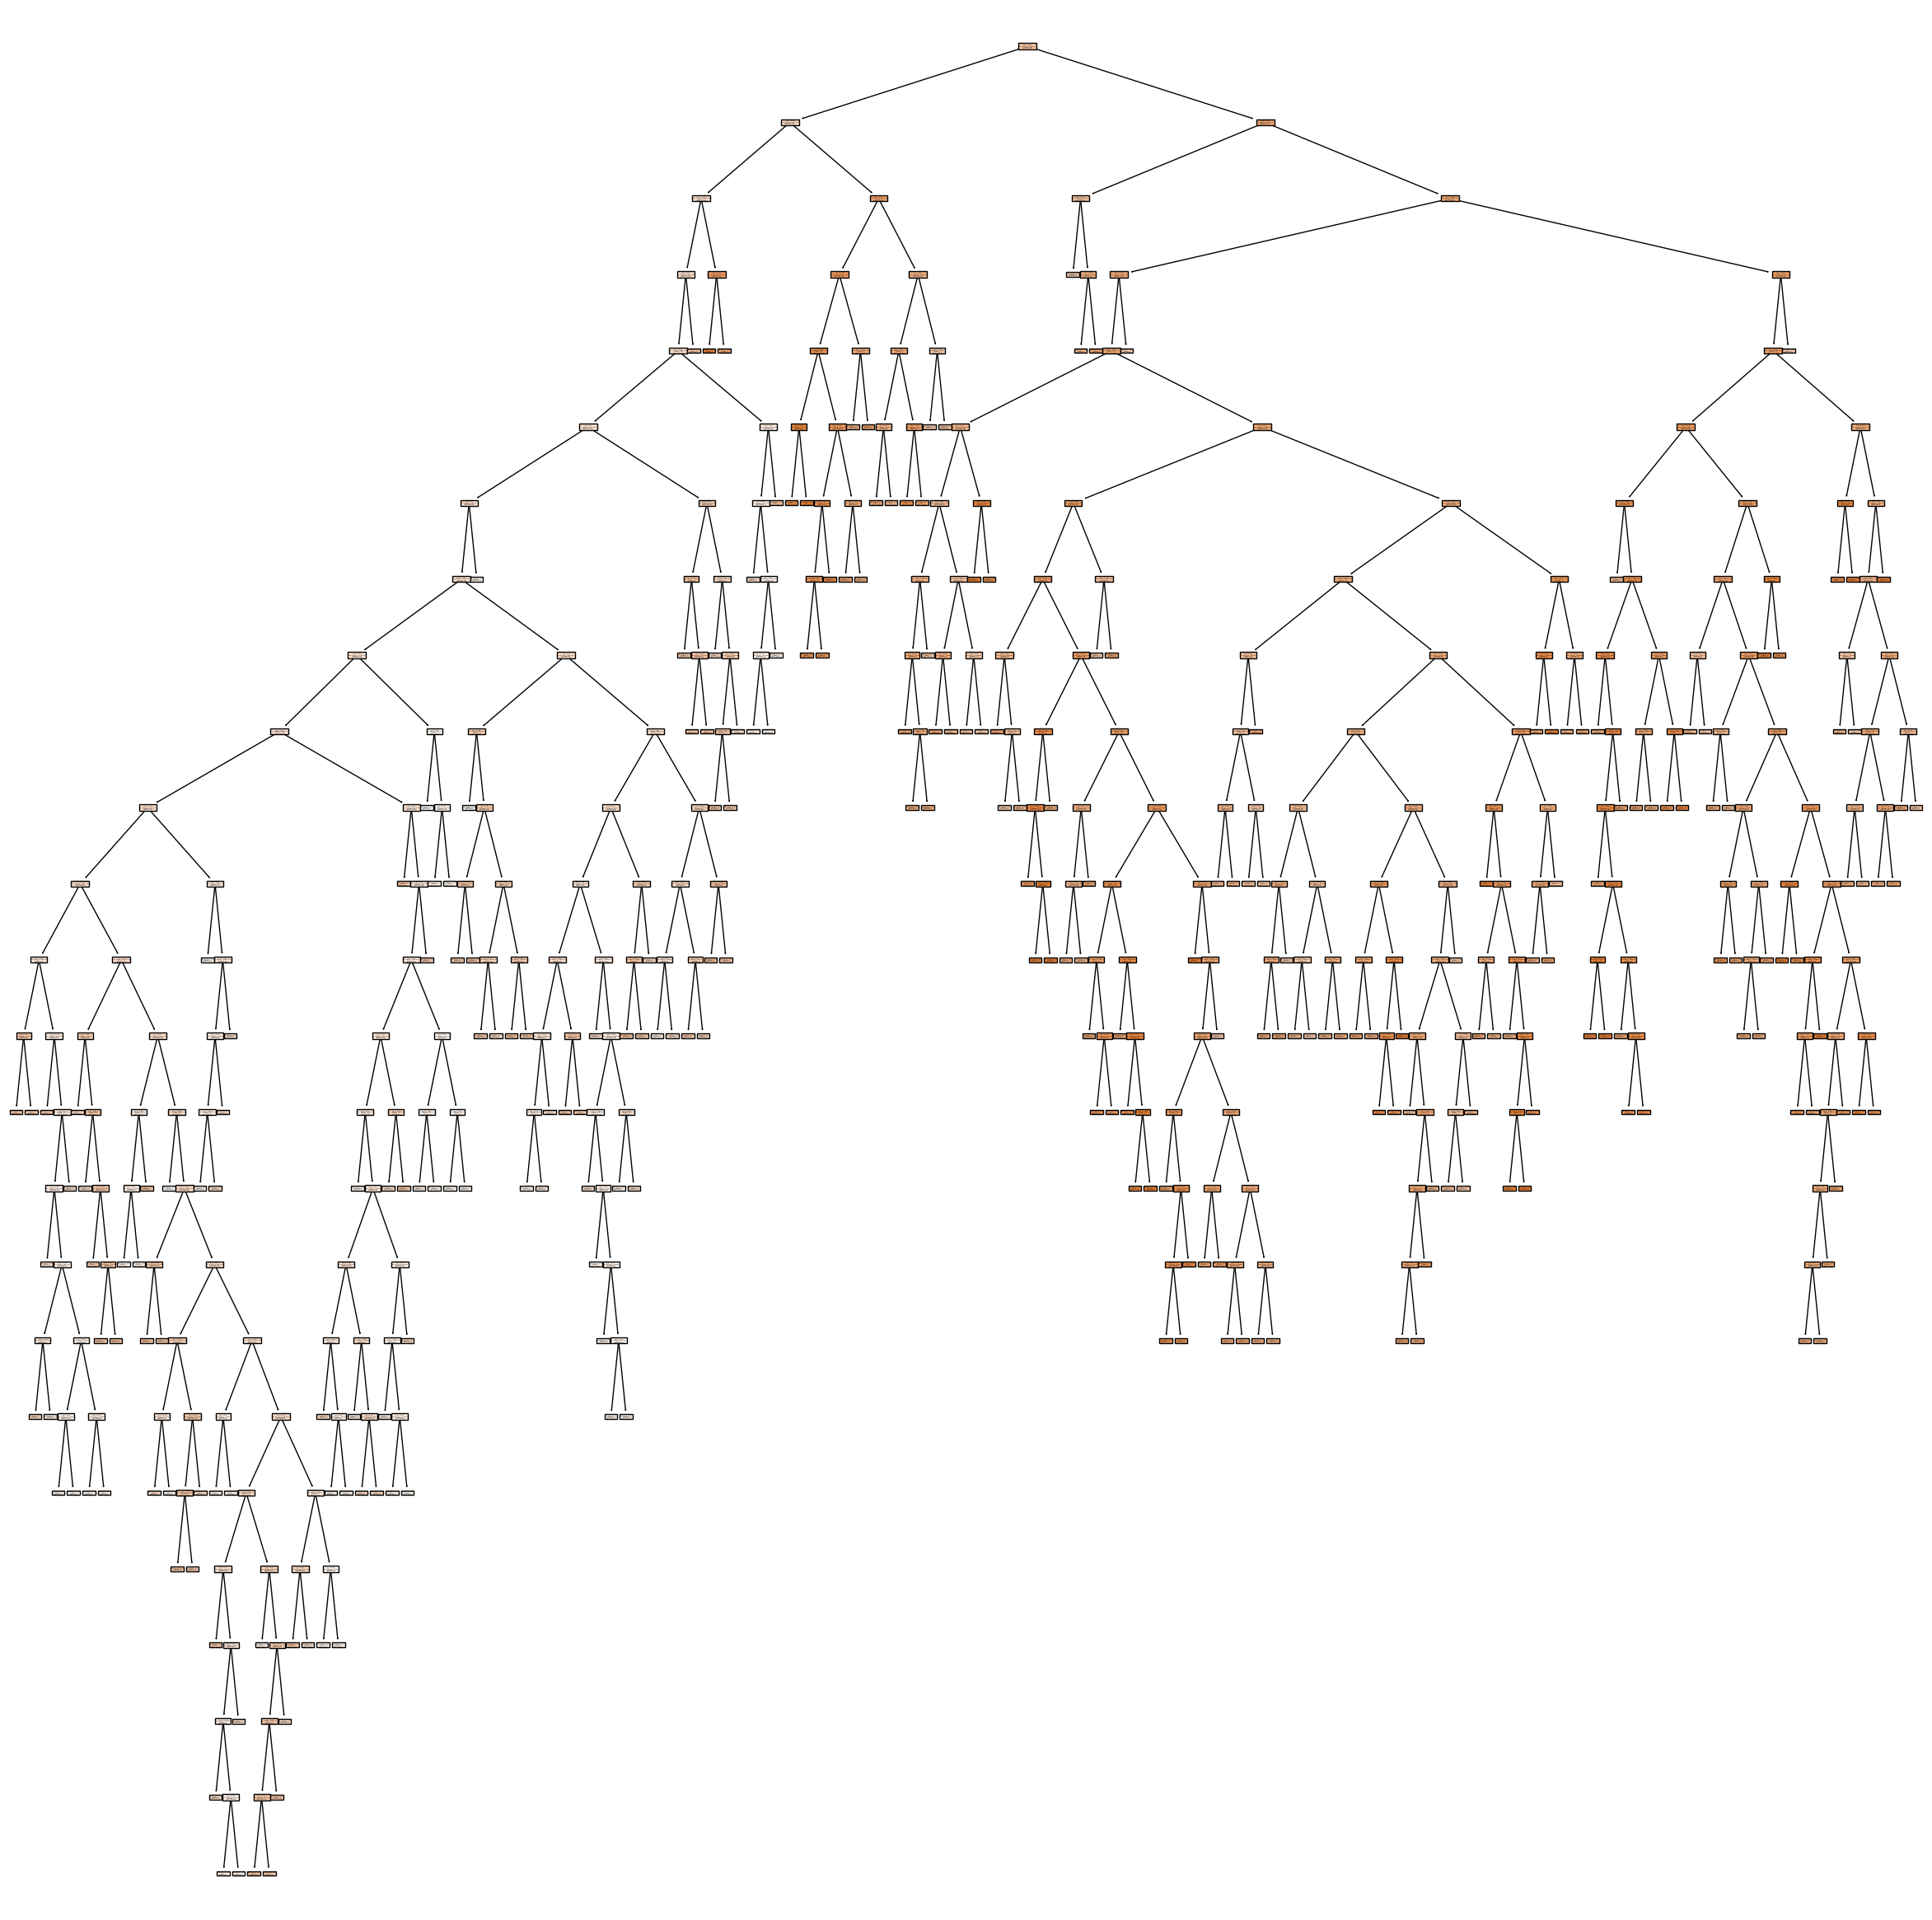

In [115]:
#Reducing OVerfitting in Decision TREE

#PLOTTING THE MODEL
plt.figure(figsize=(30,30))
tree.plot_tree(DecisionTree,filled=True);

In [90]:
#PRUNNING DECISION TREE
path = DecisionTree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

models = []
for ccp_alpha in ccp_alphas:
    model = DecisionTreeRegressor(random_state=27, ccp_alpha=ccp_alpha)
    model.fit(X_train, y_train)
    models.append(model)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      models[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 314273.3539093319


In [91]:
len(models)

215

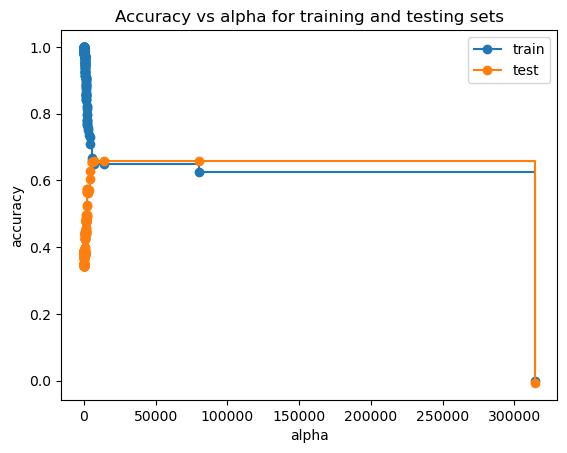

In [92]:
train_scores = [model.score(X_train, y_train) for model in models]
test_scores = [model.score(X_test, y_test) for model in models]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()

In [93]:
model = DecisionTreeRegressor(random_state=0, ccp_alpha=80000)
model.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=80000, random_state=0)

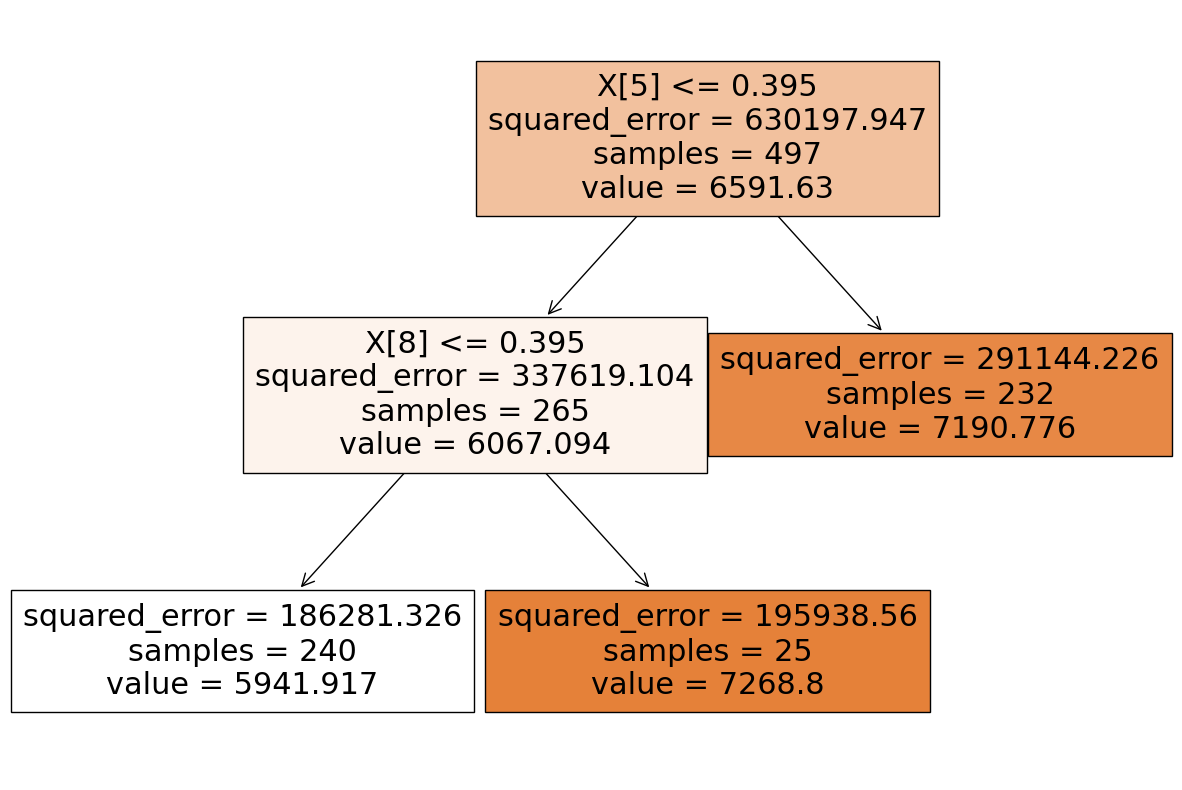

In [117]:
from sklearn import tree
plt.figure(figsize=(15,10))
tree.plot_tree(model,filled=True);

In [118]:
#prediction using top  3 models

Model_insample_predictions = model.predict(X_train)
Model_outsample_predictions = model.predict(X_test)



print("Model Insample R2 Score: {0:.2f}".format(r2_score(y_train,Model_insample_predictions)))
print("Model Outsample R2 Score: {0:.2f}".format(r2_score(y_test,Model_outsample_predictions)))


Model Insample R2 Score: 0.63
Model Outsample R2 Score: 0.66


In [176]:
Model_outsample_predictions

array([7190.77586207, 7190.77586207, 7190.77586207, 5941.91666667,
       7190.77586207, 7190.77586207, 5941.91666667, 5941.91666667,
       5941.91666667, 5941.91666667, 5941.91666667, 5941.91666667,
       7190.77586207, 7190.77586207, 5941.91666667, 7190.77586207,
       7190.77586207, 5941.91666667, 7190.77586207, 7190.77586207,
       5941.91666667, 7268.8       , 5941.91666667, 7190.77586207,
       7190.77586207, 7190.77586207, 5941.91666667, 5941.91666667,
       7190.77586207, 7190.77586207, 7190.77586207, 5941.91666667,
       5941.91666667, 7190.77586207, 5941.91666667, 5941.91666667,
       5941.91666667, 7190.77586207, 5941.91666667, 5941.91666667,
       7190.77586207, 5941.91666667, 7268.8       , 5941.91666667,
       5941.91666667, 7190.77586207, 7268.8       , 5941.91666667,
       5941.91666667, 5941.91666667, 5941.91666667, 5941.91666667,
       7268.8       , 5941.91666667, 5941.91666667, 5941.91666667,
       7190.77586207, 7190.77586207, 7190.77586207, 7190.77586

In [119]:
ExtraTrees = ExtraTreesRegressor(n_estimators= 150 , max_features='auto', n_jobs=-1,
                    random_state = 27)
ExtraTrees.fit(X_train, y_train)

ExtraTreesRegressor(max_features='auto', n_estimators=150, n_jobs=-1,
                    random_state=27)

In [120]:
insample_predictions = ExtraTrees.predict(X_train)
print("ExtraTrees Insample R2 Score: {0:.2f}".format(r2_score(y_train,insample_predictions)))

outsample_predictions = ExtraTrees.predict(X_test)
print("ExtraTrees Outsample R2 Score: {0:.2f}".format(r2_score(y_test,outsample_predictions)))

ExtraTrees Insample R2 Score: 1.00
ExtraTrees Outsample R2 Score: 0.66


In [121]:
#Combining two models
from sklearn.ensemble import VotingRegressor
Catboost = CatBoostRegressor(iterations=345, learning_rate=0.015, l2_leaf_reg = 9)
ensemble = VotingRegressor([('cb',Catboost), ('et', ExtraTrees)] ,weights = [1,2])
ensemble.fit(X_train, y_train)

0:	learn: 787.8581430	total: 1.3ms	remaining: 1.29s
1:	learn: 782.6557571	total: 2.88ms	remaining: 1.44s
2:	learn: 776.6861233	total: 4.12ms	remaining: 1.37s
3:	learn: 771.3124976	total: 5.32ms	remaining: 1.32s
4:	learn: 766.2145040	total: 6.38ms	remaining: 1.27s
5:	learn: 760.3735364	total: 7.3ms	remaining: 1.21s
6:	learn: 754.7817158	total: 8.29ms	remaining: 1.18s
7:	learn: 750.4012584	total: 9.47ms	remaining: 1.17s
8:	learn: 745.7352082	total: 10.6ms	remaining: 1.17s
9:	learn: 740.3075859	total: 11.8ms	remaining: 1.17s
10:	learn: 735.3197707	total: 12.9ms	remaining: 1.16s
11:	learn: 730.3454201	total: 14ms	remaining: 1.15s
12:	learn: 725.3099317	total: 15ms	remaining: 1.14s
13:	learn: 720.3348500	total: 15.9ms	remaining: 1.12s
14:	learn: 715.7799319	total: 17.3ms	remaining: 1.14s
15:	learn: 710.5846817	total: 18.3ms	remaining: 1.12s
16:	learn: 706.2430175	total: 19.2ms	remaining: 1.11s
17:	learn: 701.5749347	total: 20.4ms	remaining: 1.11s
18:	learn: 697.0595322	total: 21.6ms	remaini

VotingRegressor(estimators=[('cb',
                             <catboost.core.CatBoostRegressor object at 0x7f4b98a5a080>),
                            ('et',
                             ExtraTreesRegressor(max_features='auto',
                                                 n_estimators=150, n_jobs=-1,
                                                 random_state=27))],
                weights=[1, 2])

In [98]:
insample_predictions = ensemble.predict(X_train)

In [169]:
print("Enesemble Insample R2 Score: {0:.2f}".format(r2_score(y_train,insample_predictions)))
print("Enesemble Insample Mean Squared Error : {0:.2f}".format(mean_squared_error(y_train,insample_predictions)))
print("Enesemble Mean Absolute Error : {0:.2f}".format( mean_absolute_error(y_train,insample_predictions)))

Enesemble Insample R2 Score: 1.00
Enesemble Insample Mean Squared Error : 0.03
Enesemble Mean Absolute Error : 0.01


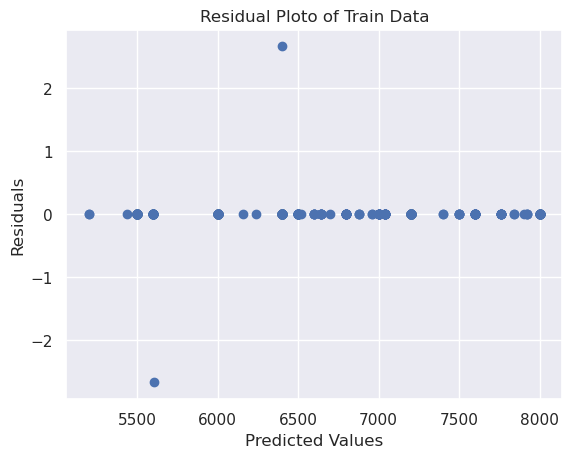

In [165]:
# plot the residuals
train_residuals = y_train - insample_predictions
plt.scatter(insample_predictions, train_residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Ploto of Train Data')
plt.show()

In [100]:
outsample_predictions = ensemble.predict(X_test)

In [170]:
print("Enesemble Outsample R2 Score: {0:.2f}".format(r2_score(y_test,outsample_predictions)))
print("Enesemble Outsample Mean Squared Error : {0:.2f}".format(mean_squared_error(y_test,outsample_predictions)))
print("Enesemble Outsample Mean Absolute Error : {0:.2f}".format( mean_absolute_error(y_test,outsample_predictions)))

Enesemble Outsample R2 Score: 0.66
Enesemble Outsample Mean Squared Error : 209956.38
Enesemble Outsample Mean Absolute Error : 369.63


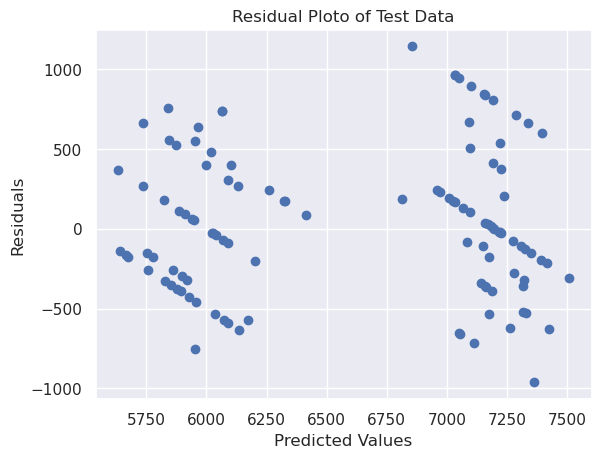

In [162]:
# plot the residuals
test_residuals = y_test - outsample_predictions
plt.scatter(outsample_predictions, test_residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Ploto of Test Data')
plt.show()

### MODEL EVALUATION

In [102]:
Districts = list(evaluation_set['District'].unique())
Districts 

['Thoai_Son', 'Chau_Thanh', 'Chau_Phu']

In [103]:

def district_evaluation(model, data):
    scores = [] 
    districts = list(data['District'].unique())
    
    for district in districts:
        df = data[data['District'] == district]
        X_test = df.drop(columns=['Rice Yield (kg/ha)', 'District']).values
        y_test = df['Rice Yield (kg/ha)'].values
        predictions = model.predict(X_test)
        score = r2_score(y_test,predictions)
        scores.append(score)
        
    df = pd.DataFrame({
    'District' : districts ,
    'R2_Score' : scores
    })
    
    return df

In [104]:
district_evaluation(ensemble, evaluation_set)

,District,R2_Score
0,Thoai_Son,0.691404
1,Chau_Thanh,0.667786
2,Chau_Phu,0.626051


### FEATURE IMPORTANCE

In [105]:
feat_importances = CatBoost.get_feature_importance(prettified=True)
feat_importances

,Feature Id,Importances
0,permutation_entropy_vh,29.364621
1,permutation_entropy_rvi,26.891162
2,permutation_entropy_vv,20.790453
3,permutation_entropy_vv_by_vh,13.018946
4,mean_vh,2.341526
5,correlation_rvi,1.753728
6,mean_vv_by_vh,1.511973
7,correlation_vh,1.008229
8,mean_vv,0.927874
9,correlation_vv,0.891563


In [107]:
shap_values = CatBoost.get_feature_importance(Pool(X_test, label=y_test) , type="ShapValues")
 
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
shap.force_plot(expected_value, shap_values[0,:], X_test.iloc[0,:])

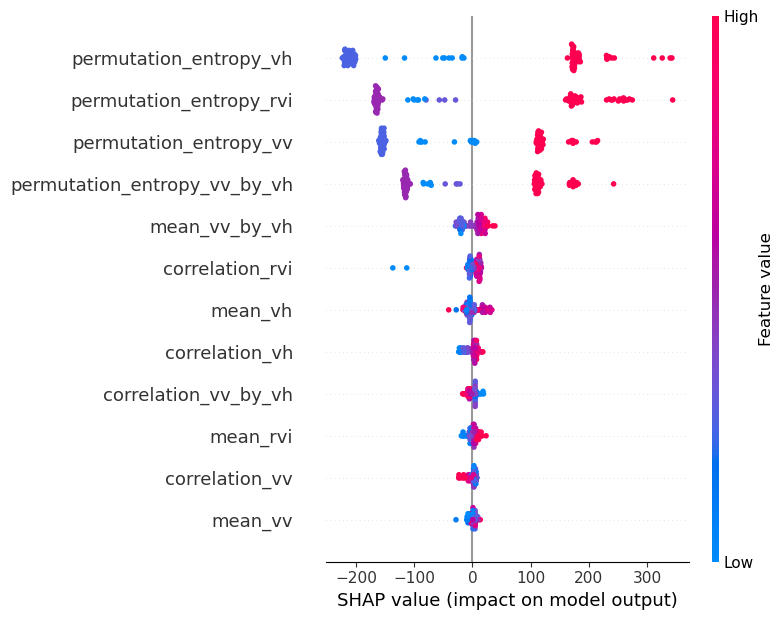

In [110]:
plt.figure(figsize=(10,10))

shap.summary_plot(shap_values, X_test)

In [123]:
data = evaluation_set[evaluation_set['Rice Yield (kg/ha)'] == evaluation_set['Rice Yield (kg/ha)'].min()]

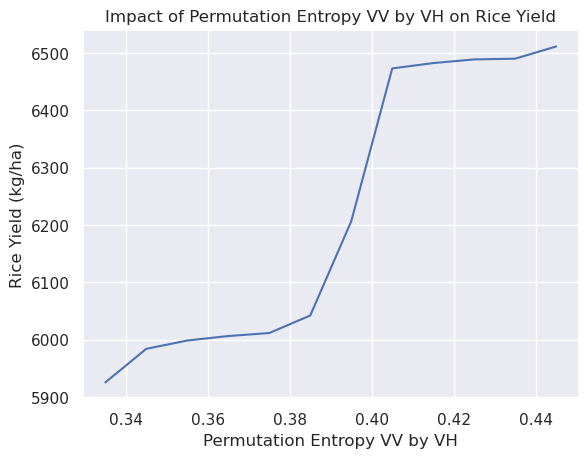

In [124]:
data = evaluation_set[evaluation_set['permutation_entropy_vv_by_vh'] == 0.32502137058457126]
final_df = data
for i in range(12):
    data['permutation_entropy_vv_by_vh'] = data['permutation_entropy_vv_by_vh'] + 0.01
    final_df = final_df.append(data)
preds = ensemble.predict(final_df.drop(columns = ['Rice Yield (kg/ha)','District']).values)
sns.set_theme()
plt.plot(final_df['permutation_entropy_vv_by_vh'] ,preds)
plt.title("Impact of Permutation Entropy VV by VH on Rice Yield") 
plt.xlabel("Permutation Entropy VV by VH")
plt.ylabel("Rice Yield (kg/ha)");

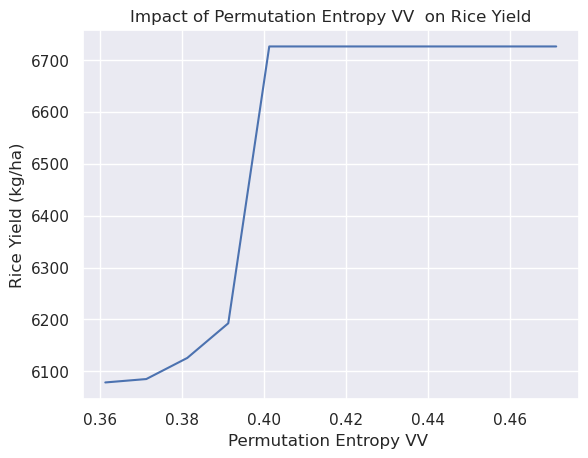

In [134]:
data = evaluation_set[evaluation_set['permutation_entropy_vv'] == 0.35132013814468477]
final_df = data
for i in range(12):
    data['permutation_entropy_vv'] = data['permutation_entropy_vv'] + 0.01
    final_df = final_df.append(data)
preds = ensemble.predict(final_df.drop(columns = ['Rice Yield (kg/ha)','District']).values)
sns.set_theme()
plt.plot(final_df['permutation_entropy_vv'] ,preds)
plt.title("Impact of Permutation Entropy VV  on Rice Yield") 
plt.xlabel("Permutation Entropy VV ")
plt.ylabel("Rice Yield (kg/ha)");

In [135]:
evaluation_set['permutation_entropy_vh'].min()

0.4011181887686231

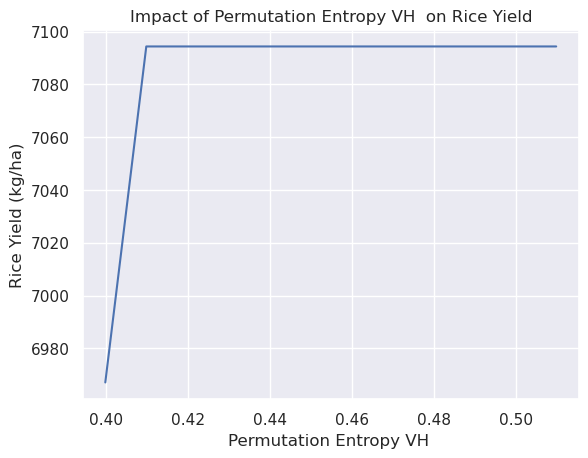

In [140]:
data = evaluation_set[evaluation_set['permutation_entropy_vv_by_vh'] == 0.32502137058457126]
final_df = data
for i in range(12):
    data['permutation_entropy_vh'] = data['permutation_entropy_vh'] + 0.01
    final_df = final_df.append(data)
preds = ensemble.predict(final_df.drop(columns = ['Rice Yield (kg/ha)','District']).values)
sns.set_theme()
plt.plot(final_df['permutation_entropy_vh'] ,preds)
plt.title("Impact of Permutation Entropy VH  on Rice Yield") 
plt.xlabel("Permutation Entropy VH ")
plt.ylabel("Rice Yield (kg/ha)");

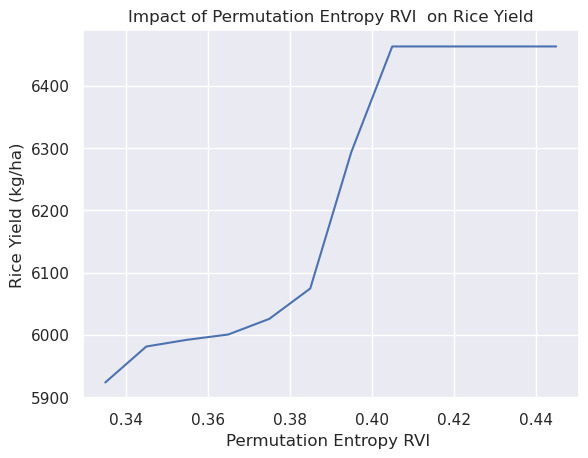

In [141]:
data = evaluation_set[evaluation_set['permutation_entropy_vv_by_vh'] == 0.32502137058457126]
final_df = data
for i in range(12):
    data['permutation_entropy_rvi'] = data['permutation_entropy_rvi'] + 0.01
    final_df = final_df.append(data)
preds = ensemble.predict(final_df.drop(columns = ['Rice Yield (kg/ha)','District']).values)
sns.set_theme()
plt.plot(final_df['permutation_entropy_rvi'] ,preds)
plt.title("Impact of Permutation Entropy RVI  on Rice Yield") 
plt.xlabel("Permutation Entropy RVI ")
plt.ylabel("Rice Yield (kg/ha)");

### SUBMISSION

In [59]:
 test_file = pd.read_csv('challenge_2_submission_template (1).csv')
test_file.head()

,ID No,District,Latitude,Longitude,"Season(SA = Summer Autumn, WS = Winter Spring)","Rice Crop Intensity(D=Double, T=Triple)",Date of Harvest,Field size (ha),Predicted Rice Yield (kg/ha)
0,1,Chau_Phu,10.542192,105.187920,WS,T,10-04-2022,1.40,NaN
1,2,Chau_Thanh,10.400189,105.331053,SA,T,15-07-2022,1.32,NaN
2,3,Chau_Phu,10.505489,105.203926,SA,D,14-07-2022,1.40,NaN
3,4,Chau_Phu,10.523520,105.138274,WS,D,10-04-2022,1.80,NaN
4,5,Thoai_Son,10.294660,105.248528,SA,T,20-07-2022,2.20,NaN


In [60]:
## Get Sentinel-1-RTC Data
assests = ['vh','vv']
submission_train_band_values=test_file.progress_apply(lambda x: get_sentinel_data(x['Longitude'], x['Latitude'],x['Season(SA = Summer Autumn, WS = Winter Spring)'],assests,0.0004), axis=1)
submission_vv_ = [x[0] for x in submission_train_band_values]
submission_vh_ = [x[1] for x in submission_train_band_values]
submission_vv_by_vh = [x[2] for x in submission_train_band_values]
submission_rvi= [x[3] for x in submission_train_band_values]

  0%|          | 0/100 [00:00<?, ?it/s]

In [171]:
submission_data = pd.DataFrame(list(zip(submission_vv_,submission_vh_,submission_vv_by_vh,submission_rvi)),columns = ["vv_list","vh_list","vv_by_vh_list","rvi_list"])

In [172]:
# Generating Statistical Features for VV,VH and VV/VH and creating a dataframe
features = generate_stastical_features(submission_data)
submission_features_data = pd.DataFrame(features ,columns = ['min_vv', 'max_vv', 'range_vv','mean_vv', 'correlation_vv', 'permutation_entropy_vv',
                                        'min_vh', 'max_vh', 'range_vh','mean_vh', 'correlation_vh', 'permutation_entropy_vh',
                                        'min_vv_by_vh', 'max_vv_by_vh', 'range_vv_by_vh', 'mean_vv_by_vh', 'correlation_vv_by_vh', 'permutation_entropy_vv_by_vh',
                                        'min_rvi', 'max_rvi', 'range_rvi', 'mean_rvi',  'correlation_rvi', 'permutation_entropy_rvi'] )

In [173]:
submission_features_data =   submission_features_data[['mean_vv', 'correlation_vv','permutation_entropy_vv',
                          'mean_vh', 'correlation_vh','permutation_entropy_vh','mean_vv_by_vh', 'correlation_vv_by_vh',
                         'permutation_entropy_vv_by_vh','mean_rvi', 'correlation_rvi','permutation_entropy_rvi']]
                                                    

In [174]:
final_predictions =  ensemble.predict(submission_features_data)
final_prediction_series = pd.Series(final_predictions)

In [151]:
#Combining the results into dataframe
test_file['Predicted Rice Yield (kg/ha)']= final_prediction_series

In [153]:
#Dumping the predictions into a csv file.
test_file.to_csv("final submision.csv",index = False)